## Heatmap: Effectiveness vs Population

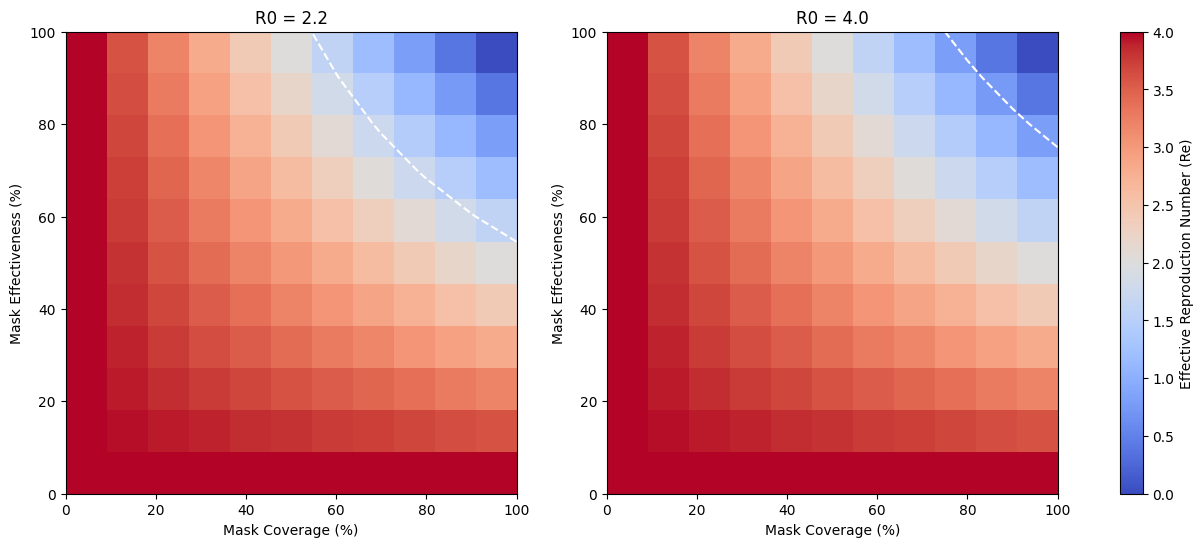

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for both scenarios
R0_values = [2.2, 4.0]  # Different R0 scenarios
mask_coverage_range = np.linspace(0, 1, 11)  # 0% to 100% in steps of 10%
mask_effectiveness_range = np.linspace(0, 1, 11)  # 0% to 100% in steps of 10%

# Create a subplot with side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, R0 in enumerate(R0_values):
    # Initialize matrix to store Re values
    Re_values = np.zeros((len(mask_coverage_range), len(mask_effectiveness_range)))

    # Calculate Re for each combination of mask coverage and effectiveness
    for i, mask_coverage in enumerate(mask_coverage_range):
        for j, mask_effectiveness in enumerate(mask_effectiveness_range):
            # Adjusted reproduction number, Re
            Re = R0 * (1 - mask_coverage * mask_effectiveness)
            Re_values[i, j] = Re

    # Plot heatmap
    im = axes[idx].imshow(Re_values, extent=[0, 100, 0, 100], origin='lower', aspect='auto', cmap='coolwarm')
    axes[idx].set_title(f"R0 = {R0}")
    axes[idx].set_xlabel("Mask Coverage (%)")
    axes[idx].set_ylabel("Mask Effectiveness (%)")
    axes[idx].set_aspect('auto')

    # Add contour for Re < 1 region
    contour = axes[idx].contour(mask_coverage_range * 100, mask_effectiveness_range * 100, Re_values, 
                                levels=[1], colors='white', linestyles='--')

# Add color bar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label="Effective Reproduction Number (Re)")
im.set_clim(0, max(R0_values))  # Update the color limits on the heatmap object

# Save the figure as a high-quality image
plt.savefig("heatmap_Re.png", dpi=300, bbox_inches='tight')  # Save as PNG with 300 DPI
plt.show()


## Various mask coverages - Lockdowns + from day 0

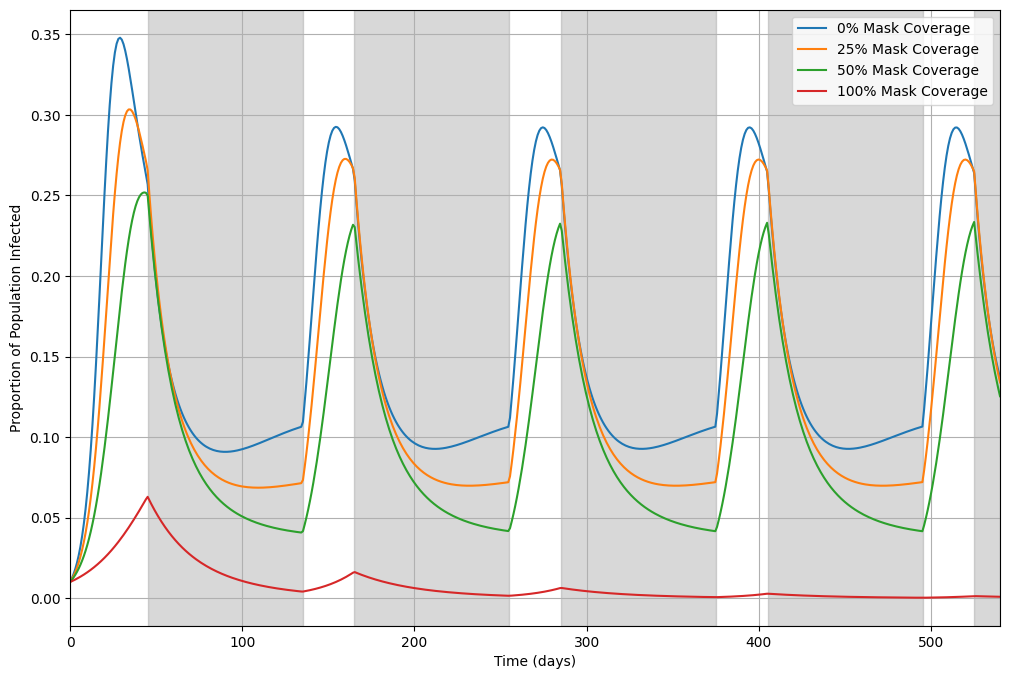

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
lockdown_reduction = 0.5    # 50% reduction in transmission during lockdown
lockdown_duration = 90      # Lockdown period in days
off_duration = 30           # Period without lockdown in days
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# First lockdown start day
first_lockdown_start = 45

# Lockdown function to check if a given day is in lockdown, starting the first lockdown on day 45
def is_in_lockdown(day):
    # Adjust day relative to the first lockdown start
    day_adjusted = day - first_lockdown_start
    if day_adjusted < 0:
        return False  # No lockdown before the first start day
    cycle_length = lockdown_duration + off_duration
    day_in_cycle = day_adjusted % cycle_length
    return day_in_cycle < lockdown_duration

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations with time-dependent infection rate
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    # Adjust the infection rate based on mask coverage
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    # Apply lockdown reduction if within lockdown period
    if is_in_lockdown(t):
        beta *= lockdown_reduction
    # SIRS equations
    dS_dt = -beta * S * I + delta * R      # Susceptible equation
    dI_dt = beta * S * I - gamma * I       # Infected equation
    dR_dt = gamma * I - delta * R          # Recovered equation
    return [dS_dt, dI_dt, dR_dt]

# Plotting setup
plt.figure(figsize=(12, 8))

# Run the model for each mask coverage percentage and plot results
for mask_coverage in mask_coverage_percentages:
    # Initial conditions for each run
    S0 = 0.99      # Initial susceptible fraction
    I0 = 0.01      # Initial infected fraction
    R0 = 0.0       # Initial recovered fraction
    initial_conditions = [S0, I0, R0]
    
    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T

    # Plot results for Infected
    plt.plot(t, I, label=f'{int(mask_coverage * 100)}% Mask Coverage')

# Highlight lockdown periods in grey, but only within 0 to 540 days
cycle_length = lockdown_duration + off_duration
for cycle_start in range(first_lockdown_start, total_days, cycle_length):
    cycle_end = cycle_start + lockdown_duration
    if cycle_start < total_days:  # Ensure start of shading is within bounds
        plt.axvspan(cycle_start, min(cycle_end, total_days), color='gray', alpha=0.3)

# Finalize plot
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population Infected')
plt.xlim(0, 540)  # Limit the x-axis to 540 days
plt.legend()
plt.grid(True)

# Save the figure as a high-quality image
plt.savefig("SIRS_Mask_Coverage_Limited.png", dpi=300, bbox_inches='tight')  # High-quality PNG
plt.show()


100% of the population being masked seems to be the only effective amount to curve the pandemic

## 100% of population masked - Various start days

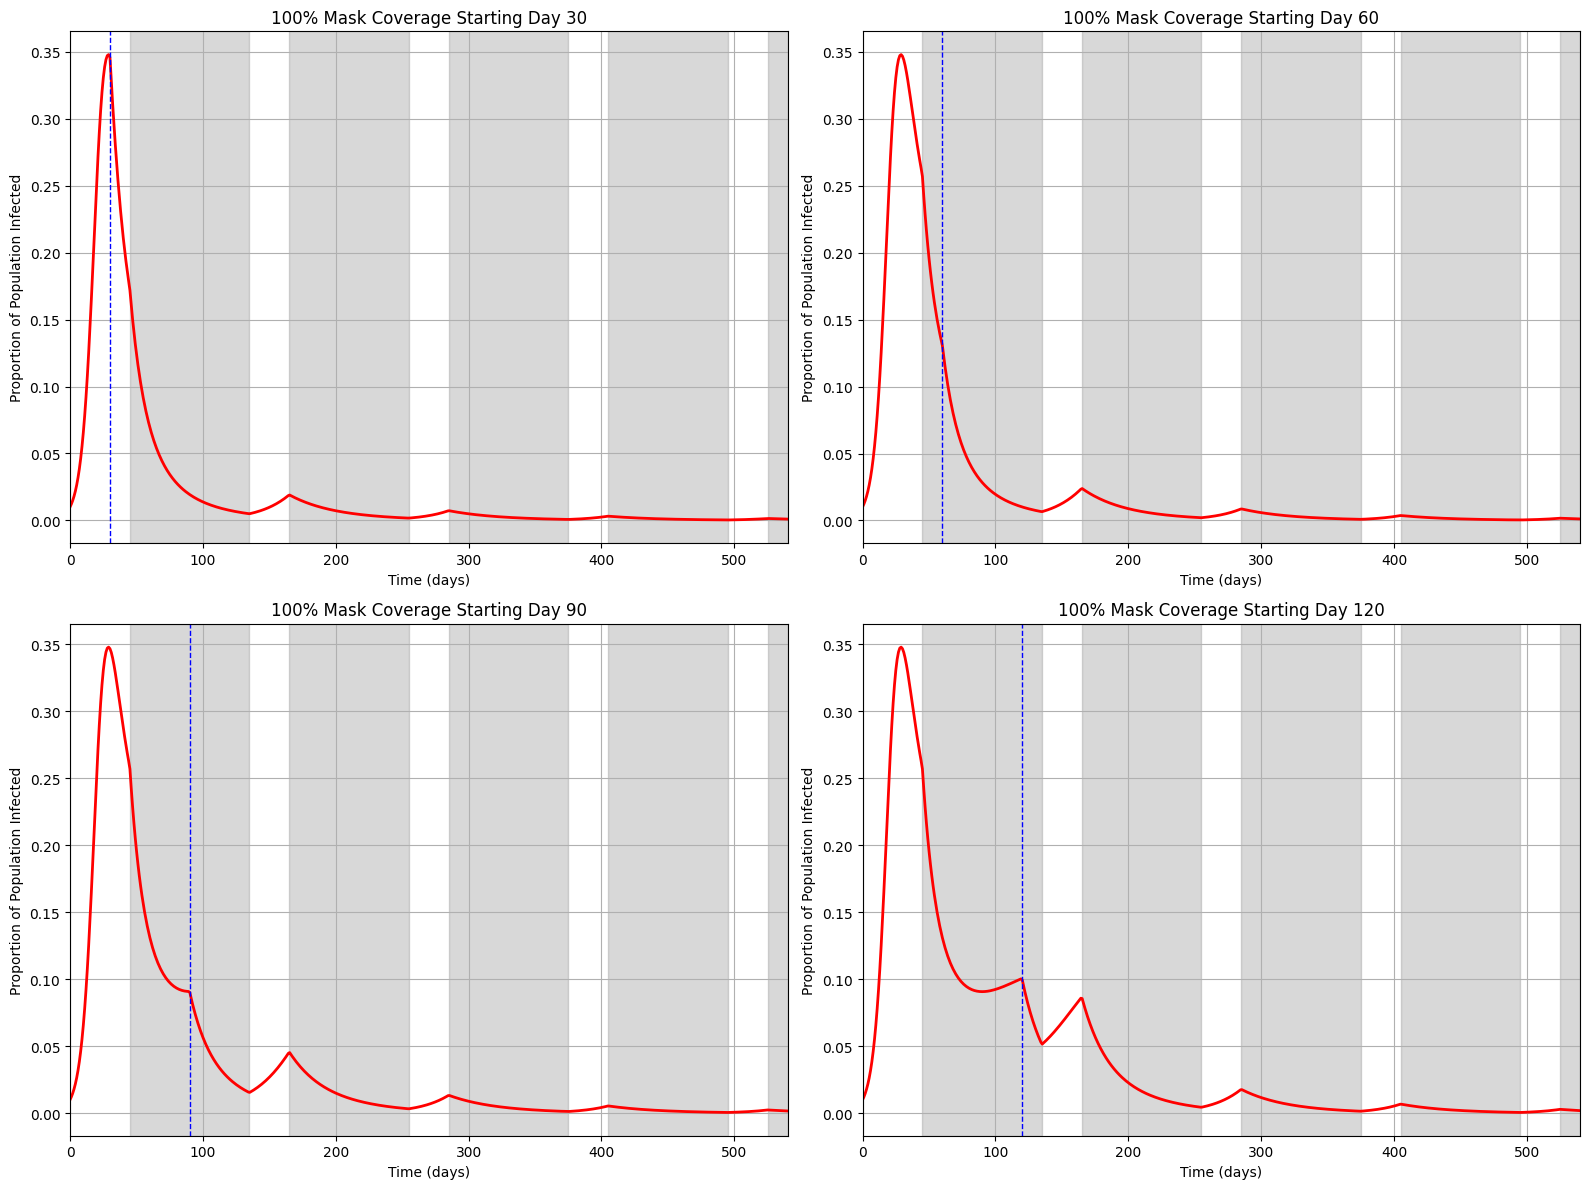

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
lockdown_reduction = 0.5    # 50% reduction in transmission during lockdown
lockdown_duration = 90      # Lockdown period in days
off_duration = 30           # Period without lockdown in days
total_days = 540            # Total simulation period in days (18 months)

# Define the days on which 100% mask coverage starts
mask_start_days = [30, 60, 90, 120]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Function to check if a given day is in a lockdown period, starting the first lockdown on day 45
first_lockdown_start = 45  # First lockdown starts on day 45

def is_in_lockdown(day):
    # Calculate day in adjusted cycle based on starting lockdown at day 45
    day_adjusted = day - first_lockdown_start
    if day_adjusted < 0:
        return False  # No lockdown before the first start day
    cycle_length = lockdown_duration + off_duration
    day_in_cycle = day_adjusted % cycle_length
    return day_in_cycle < lockdown_duration

# Time points (days)
t = np.linspace(0, total_days, total_days)

# Plotting setup with four separate graphs for each phase of mask implementation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()  # Flatten for easy indexing

# Titles for each subplot
mask_titles = {
    30: "100% Mask Coverage Starting Day 30",
    60: "100% Mask Coverage Starting Day 60",
    90: "100% Mask Coverage Starting Day 90",
    120: "100% Mask Coverage Starting Day 120"
}

# Run the model for each mask implementation day and plot results separately
for idx, mask_start_day in enumerate(mask_start_days):
    # Custom infection rate function for each mask implementation day
    def custom_infection_rate(t):
        current_coverage = 1.0 if t >= mask_start_day else 0  # 100% coverage starting from the specified day
        adjusted_beta = beta_base * (1 - current_coverage * mask_effectiveness)
        if is_in_lockdown(t):
            adjusted_beta *= lockdown_reduction
        return adjusted_beta

    # SIRS model differential equations with custom infection rate
    def sirs_model(y, t, gamma, delta):
        S, I, R = y
        beta = custom_infection_rate(t)  # Adjust infection rate for this schedule
        dS_dt = -beta * S * I + delta * R
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I - delta * R
        return [dS_dt, dI_dt, dR_dt]
    
    # Initial conditions
    S0 = 0.99
    I0 = 0.01
    R0 = 0.0
    initial_conditions = [S0, I0, R0]

    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta))
    S, I, R = solution.T

    # Plot results for Infected on each subplot
    ax = axes[idx]
    ax.plot(t, I, color='red', linewidth=2)

    # Add dashed vertical line to indicate the day mask coverage starts
    _ = ax.axvline(mask_start_day, color='blue', linestyle='--', linewidth=1)  # Avoid adding to legend

    # Highlight lockdown periods in grey
    cycle_length = lockdown_duration + off_duration
    for cycle_start in range(first_lockdown_start, total_days, cycle_length):
        ax.axvspan(cycle_start, min(cycle_start + lockdown_duration, total_days), color='gray', alpha=0.3)

    # Add titles for subplots
    ax.set_title(mask_titles[mask_start_day])

    # Customize each subplot
    ax.set_xlim(0, 540)  # Limit x-axis to 540 days
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population Infected')
    ax.grid(True)

# Adjust layout and remove overall title
plt.tight_layout()

# Save the plot as a high-quality image
plt.savefig("SIRS_Model_With_Titles.png", dpi=300, bbox_inches='tight')  # High-quality PNG
plt.show()


## Various % masked population - No Lockdown

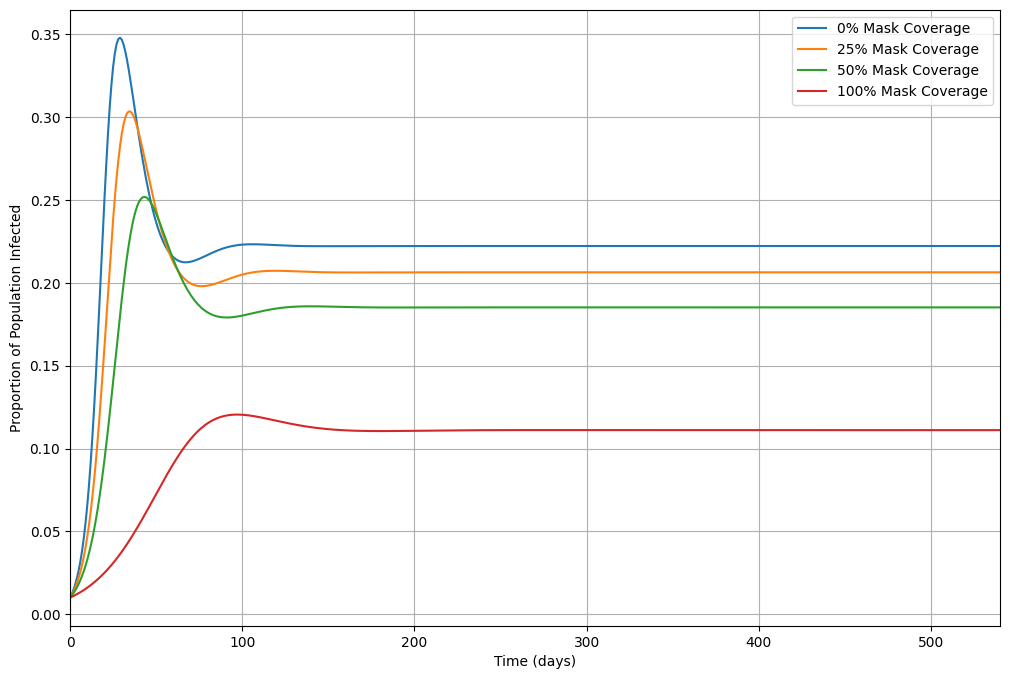

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations with time-dependent infection rate
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    # Adjust the infection rate based on mask coverage
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    # SIRS equations
    dS_dt = -beta * S * I + delta * R      # Susceptible equation
    dI_dt = beta * S * I - gamma * I       # Infected equation
    dR_dt = gamma * I - delta * R          # Recovered equation
    return [dS_dt, dI_dt, dR_dt]

# Plotting setup
plt.figure(figsize=(12, 8))

# Run the model for each mask coverage percentage and plot results
for mask_coverage in mask_coverage_percentages:
    # Initial conditions for each run
    S0 = 0.99      # Initial susceptible fraction
    I0 = 0.01      # Initial infected fraction
    R0 = 0.0       # Initial recovered fraction
    initial_conditions = [S0, I0, R0]
    
    # Solve the differential equations
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T

    # Plot results for Infected
    plt.plot(t, I, label=f'{int(mask_coverage * 100)}% Mask Coverage')

# Finalize plot
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population Infected')
plt.xlim(0, 540)  # Limit the x-axis to 540 days
plt.legend()
plt.grid(True)

# Save the plot as a high-quality image
plt.savefig("SIRS_Model_Varying_Mask_Coverage.png", dpi=300, bbox_inches='tight')  # High-quality PNG

plt.show()


## Statistical Significance

Statistical Test Results for Facemask Coverage:
Coverage: mask_25% - T-stat: 7.941, P-value: 0.000
  -> Statistically significant reduction in peak infections compared to 0% mask coverage.
Coverage: mask_50% - T-stat: 19.047, P-value: 0.000
  -> Statistically significant reduction in peak infections compared to 0% mask coverage.
Coverage: mask_100% - T-stat: 63.339, P-value: 0.000
  -> Statistically significant reduction in peak infections compared to 0% mask coverage.


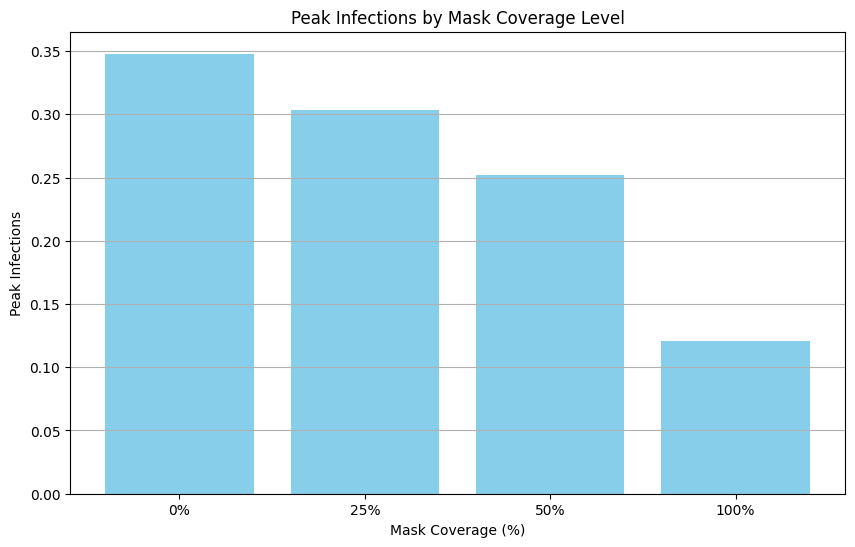

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import ttest_ind

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]  # 0% to 100% mask coverage

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    dS_dt = -beta * S * I + delta * R
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I - delta * R
    return [dS_dt, dI_dt, dR_dt]

# Run the model for each mask coverage percentage
results = {}
for mask_coverage in mask_coverage_percentages:
    S0 = 0.99
    I0 = 0.01
    R0 = 0.0
    initial_conditions = [S0, I0, R0]
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T
    results[f"mask_{int(mask_coverage * 100)}"] = I  # Store infection proportions over time

# Extract peak infections
peak_infections = [
    max(results[f"mask_{int(mask_coverage * 100)}"]) for mask_coverage in mask_coverage_percentages
]

# Perform statistical testing: Compare all mask coverage levels against 0% mask coverage
baseline_peak = results["mask_0"]  # Peak infections for 0% mask coverage
stat_results = {}
for mask_coverage in mask_coverage_percentages[1:]:  # Exclude 0% as it's the baseline
    comparison_peak = results[f"mask_{int(mask_coverage * 100)}"]
    t_stat, p_value = ttest_ind(baseline_peak, comparison_peak)
    stat_results[f"mask_{int(mask_coverage * 100)}"] = {"t_stat": t_stat, "p_value": p_value}

# Print results
print("Statistical Test Results for Facemask Coverage:")
for mask_coverage, values in stat_results.items():
    print(f"Coverage: {mask_coverage}% - T-stat: {values['t_stat']:.3f}, P-value: {values['p_value']:.3f}")
    if values["p_value"] < 0.05:
        print(f"  -> Statistically significant reduction in peak infections compared to 0% mask coverage.")
    else:
        print(f"  -> No statistically significant reduction in peak infections compared to 0% mask coverage.")

# Optional: Plot results
plt.figure(figsize=(10, 6))
plt.bar([f"{int(cov*100)}%" for cov in mask_coverage_percentages], peak_infections, color="skyblue")
plt.xlabel("Mask Coverage (%)")
plt.ylabel("Peak Infections")
plt.title("Peak Infections by Mask Coverage Level")
plt.grid(axis="y")
plt.savefig("Facemask_Significance_Test.png", dpi=300, bbox_inches="tight")  # Save plot
plt.show()


Pairwise Statistical Test Results:
Comparison: mask_25 vs. mask_50 - T-stat: 11.156, P-value: 0.000
  -> Statistically significant difference in peak infections between mask_25 and mask_50.
Comparison: mask_50 vs. mask_100 - T-stat: 45.330, P-value: 0.000
  -> Statistically significant difference in peak infections between mask_50 and mask_100.


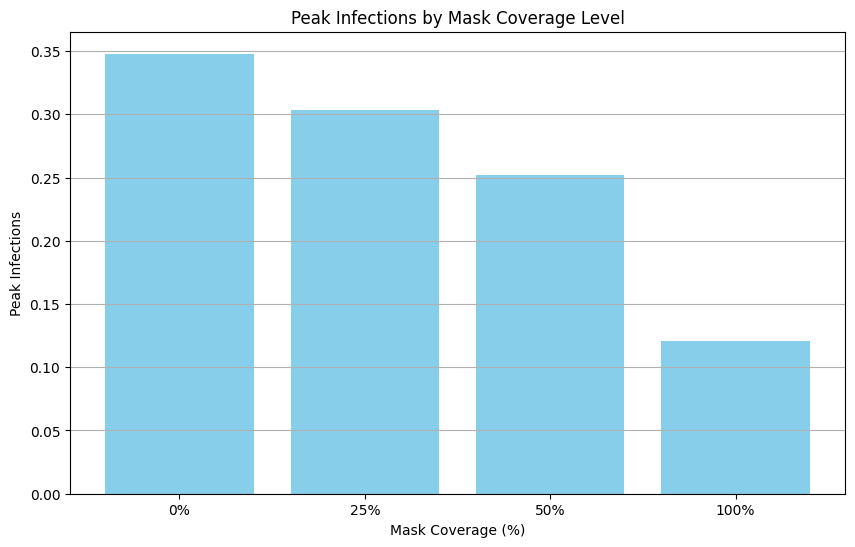

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import ttest_ind

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
total_days = 540            # Total simulation period in days (18 months)

# Define mask-wearing population percentages
mask_coverage_percentages = [0, 0.25, 0.5, 1.0]  # 0% to 100% mask coverage

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations
def sirs_model(y, t, gamma, delta, mask_coverage):
    S, I, R = y
    beta = beta_base * (1 - mask_coverage * mask_effectiveness)
    dS_dt = -beta * S * I + delta * R
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I - delta * R
    return [dS_dt, dI_dt, dR_dt]

# Run the model for each mask coverage percentage
results = {}
for mask_coverage in mask_coverage_percentages:
    S0 = 0.99
    I0 = 0.01
    R0 = 0.0
    initial_conditions = [S0, I0, R0]
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, mask_coverage))
    S, I, R = solution.T
    results[f"mask_{int(mask_coverage * 100)}"] = I  # Store infection proportions over time

# Extract peak infections
peak_infections = {
    f"mask_{int(mask_coverage * 100)}": max(results[f"mask_{int(mask_coverage * 100)}"])
    for mask_coverage in mask_coverage_percentages
}

# Perform pairwise statistical testing
pairs_to_compare = [
    ("mask_25", "mask_50"),
    ("mask_50", "mask_100")
]
stat_results = {}
for pair in pairs_to_compare:
    group1 = results[pair[0]]
    group2 = results[pair[1]]
    t_stat, p_value = ttest_ind(group1, group2)
    stat_results[pair] = {"t_stat": t_stat, "p_value": p_value}

# Print results
print("Pairwise Statistical Test Results:")
for pair, values in stat_results.items():
    print(f"Comparison: {pair[0]} vs. {pair[1]} - T-stat: {values['t_stat']:.3f}, P-value: {values['p_value']:.3f}")
    if values["p_value"] < 0.05:
        print(f"  -> Statistically significant difference in peak infections between {pair[0]} and {pair[1]}.")
    else:
        print(f"  -> No statistically significant difference in peak infections between {pair[0]} and {pair[1]}.")

# Optional: Plot results
plt.figure(figsize=(10, 6))
plt.bar([f"{int(cov*100)}%" for cov in mask_coverage_percentages], peak_infections.values(), color="skyblue")
plt.xlabel("Mask Coverage (%)")
plt.ylabel("Peak Infections")
plt.title("Peak Infections by Mask Coverage Level")
plt.grid(axis="y")
plt.savefig("Pairwise_Facemask_Significance_Test.png", dpi=300, bbox_inches="tight")  # Save plot
plt.show()


T-test Results:
T-statistic: -18.552
P-value: 0.000
-> Statistically significant difference in infections between lockdown and no-lockdown scenarios.


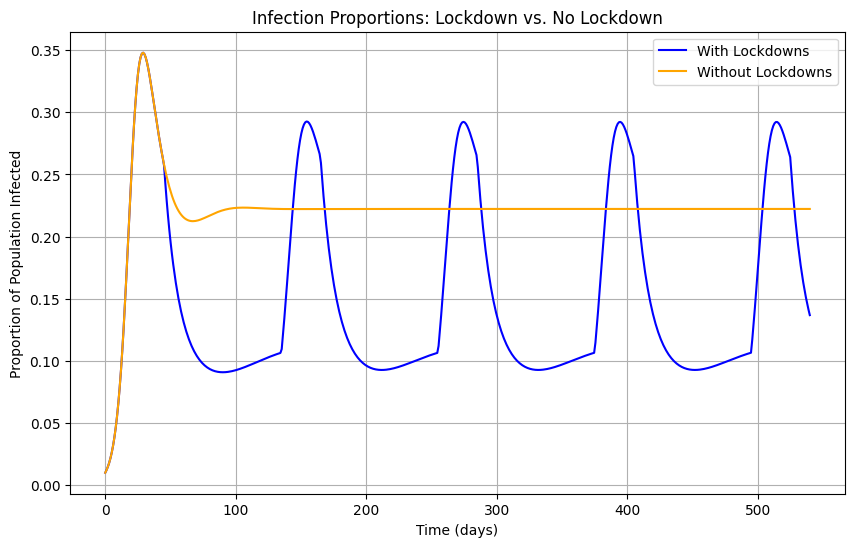

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import ttest_ind

# Parameters
R0_base = 3.0               # Basic reproduction number without intervention
gamma = 0.1                 # Recovery rate
delta = 0.05                # Rate of immunity loss
mask_effectiveness = 0.5    # Masks reduce transmission by 50%
lockdown_reduction = 0.5    # 50% reduction in transmission during lockdown
lockdown_duration = 90      # Lockdown period in days
off_duration = 30           # Period without lockdown in days
total_days = 540            # Total simulation period in days (18 months)

# Base infection rate (beta) calculated from R0 and gamma
beta_base = R0_base * gamma

# First lockdown start day
first_lockdown_start = 45  # First lockdown starts on day 45

# Lockdown function
def is_in_lockdown(day):
    # Calculate day in adjusted cycle based on starting lockdown at day 45
    day_adjusted = day - first_lockdown_start
    if day_adjusted < 0:
        return False  # No lockdown before the first start day
    cycle_length = lockdown_duration + off_duration
    day_in_cycle = day_adjusted % cycle_length
    return day_in_cycle < lockdown_duration

# Time points (days)
t = np.linspace(0, total_days, total_days)

# SIRS model differential equations
def sirs_model(y, t, gamma, delta, lockdown=True):
    S, I, R = y
    beta = beta_base
    # Adjust beta during lockdowns
    if lockdown and is_in_lockdown(t):
        beta *= lockdown_reduction
    dS_dt = -beta * S * I + delta * R
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I - delta * R
    return [dS_dt, dI_dt, dR_dt]

# Run the model for both lockdown and no-lockdown scenarios
results = {"lockdown": [], "no_lockdown": []}
for lockdown in [True, False]:
    S0 = 0.99
    I0 = 0.01
    R0 = 0.0
    initial_conditions = [S0, I0, R0]
    solution = odeint(sirs_model, initial_conditions, t, args=(gamma, delta, lockdown))
    S, I, R = solution.T
    results["lockdown" if lockdown else "no_lockdown"] = I  # Store infection proportions over time

# Extract peak infections
peak_lockdown = max(results["lockdown"])      # Peak infections during lockdown
peak_no_lockdown = max(results["no_lockdown"])  # Peak infections without lockdown

# Perform a t-test
t_stat, p_value = ttest_ind(results["lockdown"], results["no_lockdown"])

# Print results
print(f"T-test Results:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")
if p_value < 0.05:
    print("-> Statistically significant difference in infections between lockdown and no-lockdown scenarios.")
else:
    print("-> No statistically significant difference in infections between lockdown and no-lockdown scenarios.")

# Optional: Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, results["lockdown"], label="With Lockdowns", color="blue")
plt.plot(t, results["no_lockdown"], label="Without Lockdowns", color="orange")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of Population Infected")
plt.title("Infection Proportions: Lockdown vs. No Lockdown")
plt.legend()
plt.grid(True)
plt.savefig("Lockdown_vs_NoLockdown.png", dpi=300, bbox_inches="tight")  # Save plot
plt.show()
